## Standard Continuous Time Lyapunov Equation

In [1]:
import scipy
import control
import numpy as np
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Markdown, display
from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)
from pydrake.examples.pendulum import PendulumParams
from pydrake.examples.van_der_pol import VanDerPolOscillator
from pydrake.symbolic import Polynomial

from underactuated import plot_2d_phase_portrait, running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()

import math

In [18]:
f = lambda x: [- x[1], x[0] + (x[0]**2 - 1) * x[1]]

In [19]:
A = np.array([[0, -1], [1, -1]])
Q = np.eye(2)

In [20]:
X1 = control.lyap(A.T, Q)

In [21]:
X1

array([[ 1.5, -0.5],
       [-0.5,  1. ]])

In [22]:
E = np.eye(2)

In [23]:
X2 = control.lyap(A.T, Q, E = E)

In [24]:
X2

array([[ 1.5, -0.5],
       [-0.5,  1. ]])

## Cart Pole Dynamics

For reference of dynamics, see Shen Shen's quotient ring optimization paper. 
Assume unit mass and unit length

Write the dynamics as 
M $\times$ y = F

In [25]:
g, t = sp.symbols('g t')
u = sp.symbols('u')
q0, q1 = dynamicsymbols('q0 q1')

In [26]:
q0_dot = sp.diff(q0, t)
q1_dot = sp.diff(q1, t)

q0_dotdot = sp.diff(q0_dot, t)
q1_dotdot = sp.diff(q1_dot, t)

In [36]:
# state vector
y = sp.Matrix([q0, q1, q0_dot, q1_dot])
y_dot = sp.Matrix([q0_dot, q1_dot, q0_dotdot, q1_dotdot])

# force vector
F = sp.Matrix([q0_dot, q1_dot, -(q1_dot**2)*sp.sin(q1), 1*g*sp.sin(q1)])

# mass matrix
M = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, sp.cos(q1)], [0, 0, sp.cos(q1), 1]]) 

## Cart Pole Explicitly

Write the dynamics as $\dot{y}$ = f(y)

In [37]:
f = sp.simplify(M.inv()*F)

f

Matrix([
[                                                      Derivative(q0(t), t)],
[                                                      Derivative(q1(t), t)],
[   (g*cos(q1(t)) + Derivative(q1(t), t)**2)*sin(q1(t))/(cos(q1(t))**2 - 2)],
[-(2*g + cos(q1(t))*Derivative(q1(t), t)**2)*sin(q1(t))/(cos(q1(t))**2 - 2)]])

In [39]:
# linearize now
A = f.jacobian(y)

# substitute values at equilibrium point
sp.simplify(A.subs([(q1, sp.pi), (g, 1)]))

Matrix([
[0,  0, 1, 0],
[0,  0, 0, 1],
[0, -1, 0, 0],
[0, -2, 0, 0]])

In [40]:
A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 10, 0, 0], [0, 20, 0, 0]])
Q = np.eye(4)

In [41]:
X1 = control.lyap(A.T, Q)

SlycotResultWarning: 
The matrices `A` and `-A'` have common or very close eigenvalues

In [42]:
P = RealContinuousLyapunovEquation(A, Q)

RuntimeError: RealContinuousLyapunovEquation(): Solution is not unique!

## Cart Pole Implicitly

In [85]:
A = F.jacobian(y)
A.subs([(q1, sp.pi/2)])

Matrix([
[0,                    0, 1, 0],
[0,                    0, 0, 1],
[0, -Derivative(pi/2, t), 0, 0],
[0,                    g, 0, 0]])

In [83]:
E = np.eye(4)
E[2, 2] = 2

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 1.]])

In [86]:
A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 10, 0, 0]])

In [88]:
X2 = control.lyap(A.T, Q, E = E)

SlycotResultWarning: 
DICO = 'C' and the pencil A - lambda * E has a
degenerate pair of eigenvalues. That is, lambda_i =
-lambda_j for some i and j, where lambda_i and
lambda_j are eigenvalues of A - lambda * E. Hence,
equation (1) is singular;  perturbed values were
used to solve the equation (but the matrices A and
E are unchanged).

In [3]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem)
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState)
from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant,
                                        StabilizingLQRController)
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

from underactuated import FindResource, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()


In [90]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [91]:
def cartpole_balancing_example():
    def UprightState():
        state = (0, np.pi, 0, 0)
        return state

    def Controllability(plant):
        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])
        plant.SetPositionsAndVelocities(context, UprightState())

        linearized_plant = Linearize(
            plant,
            context,
            input_port_index=plant.get_actuation_input_port().get_index(), output_port_index=plant.get_state_output_port().get_index())
        print(linearized_plant.A())
        print(linearized_plant.B())
        print(
            f"The singular values of the controllability matrix are: {np.linalg.svd(ControllabilityMatrix(linearized_plant), compute_uv=False)}"
        )

    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        plant.SetPositionsAndVelocities(context, UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = np.array([1])

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index())


    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    file_name = FindResource("models/cartpole.urdf")
    Parser(plant).AddModelFromFile(file_name)
    plant.Finalize()

    controller = builder.AddSystem(BalancingLQR(plant))
    builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0),
                    plant.get_actuation_input_port())

    # Setup visualization
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
    MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    duration = 5.0 if running_as_notebook else 0.1
    for i in range(5):
        context.SetTime(0.)
        plant.SetPositionsAndVelocities(
            plant_context,
            UprightState() + 0.1 * np.random.randn(4,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
cartpole_balancing_example()

In [56]:
def UprightState():
    state = (0, np.pi, 0, 0)
    return state


builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
file_name = FindResource("models/cartpole.urdf")
Parser(plant).AddModelFromFile(file_name)
plant.Finalize()


context = plant.CreateDefaultContext()
plant.get_actuation_input_port().FixValue(context, [0])
plant.SetPositionsAndVelocities(context, UprightState())

linearized_plant = Linearize(
    plant,
    context,
    input_port_index=plant.get_actuation_input_port().get_index(), output_port_index=plant.get_state_output_port().get_index())

print(linearized_plant.A())
print(linearized_plant.B())
print(
    f"The singular values of the controllability matrix are: {np.linalg.svd(ControllabilityMatrix(linearized_plant), compute_uv=False)}"
)

[[1.      0.00981 0.1     0.     ]
 [0.      1.21582 0.      0.1    ]
 [0.      0.0981  1.      0.     ]
 [0.      2.1582  0.      1.     ]]
[[0.001]
 [0.002]
 [0.01 ]
 [0.02 ]]
The singular values of the controllability matrix are: [7.34703681e-02 6.86635424e-03 9.15774466e-04 3.33296725e-05]


In [82]:
A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 4.91, 0, 0]])
M = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 11, -0.5], [0, 0, -0.5, 0.25]])

ans = np.linalg.inv(M)@A

In [83]:
ans

array([[ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.982,  0.   ,  0.   ],
       [ 0.   , 21.604,  0.   ,  0.   ]])

In [112]:
from pydrake.examples.pendulum import PendulumParams, PendulumPlant

p = PendulumParams()

b = p.damping()
m = p.mass()
length = p.length()
g = p.gravity()
grav = p.gravity()

## Simple Pendulum Example

In [113]:
# explicit dynamics
plant = PendulumPlant()
context = plant.CreateDefaultContext()
plant.get_input_port().FixValue(context, [0])
context.SetContinuousState([0, 0])

linearized_plant = Linearize(plant, context)

A = linearized_plant.A()
Q = np.eye(2)
P = RealContinuousLyapunovEquation(A, Q)
X1 = control.lyap(A.T, Q)

In [114]:
P

array([[2.57851937e+01, 2.54841998e-02],
       [2.54841998e-02, 1.31371050e+00]])

In [103]:
A

array([[  0.  ,   1.  ],
       [-19.62,  -0.4 ]])

In [104]:
X1

array([[2.57851937e+01, 2.54841998e-02],
       [2.54841998e-02, 1.31371050e+00]])

In [106]:
# implicit dynamics
E = np.array([[1, 0], [0, m*(l**2)]])
A = np.array([[0, 1], [-m*g*l, -b]])

X2 = control.lyap(A.T, Q, E = E.T)

TypeError: failed in converting 7th argument `a' of _wrapper.sg03ad to C/Fortran array

In [107]:
X2

NameError: name 'X2' is not defined

In [108]:
S = E.T@X2@E
S

NameError: name 'X2' is not defined

### Using these solutions as starting candidates for alternations

For this we first need to do a change or coordinates: $\tilde{\theta} = \theta - \pi$ 

The dynamics now become: 
$ml^2\ddot{\tilde{\theta}} + b\dot{\tilde{\theta}} - mgl\sin{\tilde{\theta}} = 0$

In this case, this doesn't change the value of the matrices found above

In [121]:
#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(1e-5))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5), np.array(lambda_g_results)

def find_implicit_V(x, xd, lambda_, lambda_g, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
        
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
    
    prog.AddLinearCost(np.trace(Q))    
    #prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0, xd[0]: 0, xd[1]: 0}) == 0)
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit(S, V_degree):
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    xd = prog.NewIndeterminates(2, "xd")
        
    g0 = xd[0] - x[1]
    g1 = m*(length**2)*xd[1] + b*x[1] + m*grav*length*x[0]
    
    g = np.array([g0, g1])
    
    V = x.T@P@x
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(200):
        lambda_, lambda_g = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
#         print(alpha)
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(P, V_degree)

$ V(x)=(0.050968400x_{0} x_{1} + 25.785193680x_{0}^{2} + 1.313710499x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.058812414x_{0} x_{1} + 25.148088222x_{0}^{2} + 1.279074892x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.063062259x_{0} x_{1} + 24.528546646x_{0}^{2} + 1.245323622x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.064968877x_{0} x_{1} + 23.926033185x_{0}^{2} + 1.212707138x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.065348478x_{0} x_{1} + 23.339922999x_{0}^{2} + 1.181285676x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.064753292x_{0} x_{1} + 22.769838045x_{0}^{2} + 1.151047863x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.063553842x_{0} x_{1} + 22.215513589x_{0}^{2} + 1.121946112x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.061992585x_{0} x_{1} + 21.676668112x_{0}^{2} + 1.093914689x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.060223633x_{0} x_{1} + 21.152945734x_{0}^{2} + 1.066880944x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.058339288x_{0} x_{1} + 20.643961091x_{0}^{2} + 1.040774631x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.056388604x_{0} x_{1} + 20.149795307x_{0}^{2} + 1.015557919x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.054406766x_{0} x_{1} + 19.670145103x_{0}^{2} + 0.991179873x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.052421773x_{0} x_{1} + 19.204758276x_{0}^{2} + 0.967601764x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.050454735x_{0} x_{1} + 18.753462585x_{0}^{2} + 0.944795388x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.048502406x_{0} x_{1} + 18.316142151x_{0}^{2} + 0.922736190x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.046550772x_{0} x_{1} + 17.892808844x_{0}^{2} + 0.901409545x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.044636063x_{0} x_{1} + 17.483367450x_{0}^{2} + 0.880809951x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.042828506x_{0} x_{1} + 17.086447403x_{0}^{2} + 0.860871777x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.041147912x_{0} x_{1} + 16.700907971x_{0}^{2} + 0.841530250x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.039604207x_{0} x_{1} + 16.325870312x_{0}^{2} + 0.822734641x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.038198083x_{0} x_{1} + 15.960608778x_{0}^{2} + 0.804442296x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.036925433x_{0} x_{1} + 15.604530109x_{0}^{2} + 0.786617988x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.035772139x_{0} x_{1} + 15.257042083x_{0}^{2} + 0.769226494x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.034701269x_{0} x_{1} + 14.913413128x_{0}^{2} + 0.752037363x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.033720285x_{0} x_{1} + 14.573180316x_{0}^{2} + 0.735017676x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.032826816x_{0} x_{1} + 14.237446677x_{0}^{2} + 0.718212557x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.032002292x_{0} x_{1} + 13.907117504x_{0}^{2} + 0.701661190x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.031224626x_{0} x_{1} + 13.582843811x_{0}^{2} + 0.685393846x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.030475419x_{0} x_{1} + 13.265006543x_{0}^{2} + 0.669430315x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.029742875x_{0} x_{1} + 12.953754952x_{0}^{2} + 0.653780828x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.029021052x_{0} x_{1} + 12.649074979x_{0}^{2} + 0.638448301x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.028308617x_{0} x_{1} + 12.350856852x_{0}^{2} + 0.623430974x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.027607012x_{0} x_{1} + 12.058944681x_{0}^{2} + 0.608724382x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.026918866x_{0} x_{1} + 11.773166981x_{0}^{2} + 0.594322609x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.026246928x_{0} x_{1} + 11.493352623x_{0}^{2} + 0.580219039x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.025593606x_{0} x_{1} + 11.219337707x_{0}^{2} + 0.566406816x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.024960469x_{0} x_{1} + 10.950968160x_{0}^{2} + 0.552878978x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.024348432x_{0} x_{1} + 10.688099028x_{0}^{2} + 0.539628684x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.023757648x_{0} x_{1} + 10.430594662x_{0}^{2} + 0.526649260x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.023187837x_{0} x_{1} + 10.178325238x_{0}^{2} + 0.513934156x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.022638275x_{0} x_{1} + 9.931165462x_{0}^{2} + 0.501476970x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.022107885x_{0} x_{1} + 9.688993945x_{0}^{2} + 0.489271417x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.021595431x_{0} x_{1} + 9.451692346x_{0}^{2} + 0.477311367x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.021099692x_{0} x_{1} + 9.219144886x_{0}^{2} + 0.465590855x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.020615720x_{0} x_{1} + 8.991334957x_{0}^{2} + 0.454110153x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.020142052x_{0} x_{1} + 8.768215349x_{0}^{2} + 0.442867016x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.019679326x_{0} x_{1} + 8.549678618x_{0}^{2} + 0.431855288x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.019227384x_{0} x_{1} + 8.335617397x_{0}^{2} + 0.421068978x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.018785814x_{0} x_{1} + 8.125925767x_{0}^{2} + 0.410502354x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.018354398x_{0} x_{1} + 7.920499970x_{0}^{2} + 0.400149999x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.017933129x_{0} x_{1} + 7.719238837x_{0}^{2} + 0.390006766x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.017522304x_{0} x_{1} + 7.522043545x_{0}^{2} + 0.380067751x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.017119926x_{0} x_{1} + 7.328813612x_{0}^{2} + 0.370329734x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.016732277x_{0} x_{1} + 7.139462429x_{0}^{2} + 0.360784786x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.016355948x_{0} x_{1} + 6.953888888x_{0}^{2} + 0.351429912x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.015991160x_{0} x_{1} + 6.771998287x_{0}^{2} + 0.342260427x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.015637658x_{0} x_{1} + 6.593694899x_{0}^{2} + 0.333271507x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.015294729x_{0} x_{1} + 6.418882231x_{0}^{2} + 0.324458209x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014961207x_{0} x_{1} + 6.247462956x_{0}^{2} + 0.315815489x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014635600x_{0} x_{1} + 6.079339173x_{0}^{2} + 0.307338252x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014316121x_{0} x_{1} + 5.914412950x_{0}^{2} + 0.299021365x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.014000898x_{0} x_{1} + 5.752586699x_{0}^{2} + 0.290859733x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.013684698x_{0} x_{1} + 5.593698448x_{0}^{2} + 0.282845202x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.013365103x_{0} x_{1} + 5.437612517x_{0}^{2} + 0.274970856x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.013038796x_{0} x_{1} + 5.284210864x_{0}^{2} + 0.267230267x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012702156x_{0} x_{1} + 5.133356143x_{0}^{2} + 0.259616074x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.012350403x_{0} x_{1} + 4.984883001x_{0}^{2} + 0.252119420x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012099064x_{0} x_{1} + 4.840036081x_{0}^{2} + 0.244816697x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.011966450x_{0} x_{1} + 4.699372127x_{0}^{2} + 0.237733835x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.012148593x_{0} x_{1} + 4.563590657x_{0}^{2} + 0.230936736x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.012135064x_{0} x_{1} + 4.429993373x_{0}^{2} + 0.224202374x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012023099x_{0} x_{1} + 4.298939328x_{0}^{2} + 0.217575319x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.011843261x_{0} x_{1} + 4.170417850x_{0}^{2} + 0.211065052x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.011606664x_{0} x_{1} + 4.044474226x_{0}^{2} + 0.204678223x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.011267402x_{0} x_{1} + 3.921339974x_{0}^{2} + 0.198420361x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.010855508x_{0} x_{1} + 3.800043777x_{0}^{2} + 0.192250644x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.010549966x_{0} x_{1} + 3.681560564x_{0}^{2} + 0.186249505x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.010333458x_{0} x_{1} + 3.565831329x_{0}^{2} + 0.180404157x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.010178386x_{0} x_{1} + 3.452797806x_{0}^{2} + 0.174702766x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.010054140x_{0} x_{1} + 3.342358717x_{0}^{2} + 0.169133271x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.009941641x_{0} x_{1} + 3.234473440x_{0}^{2} + 0.163690371x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.009975593x_{0} x_{1} + 3.130050801x_{0}^{2} + 0.158441892x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.009946074x_{0} x_{1} + 3.028227903x_{0}^{2} + 0.153306381x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.009820316x_{0} x_{1} + 2.929118349x_{0}^{2} + 0.148292068x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.009629065x_{0} x_{1} + 2.832754005x_{0}^{2} + 0.143409642x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.009394353x_{0} x_{1} + 2.739136562x_{0}^{2} + 0.138664237x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.009131659x_{0} x_{1} + 2.648247172x_{0}^{2} + 0.134057468x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.008851749x_{0} x_{1} + 2.560053399x_{0}^{2} + 0.129588811x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.008561533x_{0} x_{1} + 2.474509410x_{0}^{2} + 0.125256176x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.008266223x_{0} x_{1} + 2.391566981x_{0}^{2} + 0.121057055x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.007969662x_{0} x_{1} + 2.311174193x_{0}^{2} + 0.116988590x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.007674672x_{0} x_{1} + 2.233273581x_{0}^{2} + 0.113047572x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.007383530x_{0} x_{1} + 2.157800040x_{0}^{2} + 0.109230421x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.007099169x_{0} x_{1} + 2.084679304x_{0}^{2} + 0.105533243x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006825812x_{0} x_{1} + 2.013814416x_{0}^{2} + 0.101951170x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006569723x_{0} x_{1} + 1.945047147x_{0}^{2} + 0.098476348x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.006344132x_{0} x_{1} + 1.878120915x_{0}^{2} + 0.095096557x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006064789x_{0} x_{1} + 1.814274805x_{0}^{2} + 0.091865260x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.005743952x_{0} x_{1} + 1.753649731x_{0}^{2} + 0.088793259x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.005384609x_{0} x_{1} + 1.696230216x_{0}^{2} + 0.085881386x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004979457x_{0} x_{1} + 1.641091998x_{0}^{2} + 0.083082949x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004556271x_{0} x_{1} + 1.588169506x_{0}^{2} + 0.080397152x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004132255x_{0} x_{1} + 1.537311240x_{0}^{2} + 0.077817496x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.003719706x_{0} x_{1} + 1.488457355x_{0}^{2} + 0.075341535x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.003360300x_{0} x_{1} + 1.441666565x_{0}^{2} + 0.072976167x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002999656x_{0} x_{1} + 1.395795933x_{0}^{2} + 0.070655367x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002901085x_{0} x_{1} + 1.352952609x_{0}^{2} + 0.068517083x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.002775932x_{0} x_{1} + 1.311584104x_{0}^{2} + 0.066444398x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002635739x_{0} x_{1} + 1.271645992x_{0}^{2} + 0.064437901x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002480937x_{0} x_{1} + 1.233056137x_{0}^{2} + 0.062494417x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002193082x_{0} x_{1} + 1.194776911x_{0}^{2} + 0.060546790x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002117354x_{0} x_{1} + 1.160387386x_{0}^{2} + 0.058822681x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001857103x_{0} x_{1} + 1.126133563x_{0}^{2} + 0.057082428x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001862439x_{0} x_{1} + 1.094730649x_{0}^{2} + 0.055513236x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001776100x_{0} x_{1} + 1.064725891x_{0}^{2} + 0.054002218x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001716553x_{0} x_{1} + 1.035988622x_{0}^{2} + 0.052555956x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001684921x_{0} x_{1} + 1.008205567x_{0}^{2} + 0.051158157x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001677205x_{0} x_{1} + 0.981008821x_{0}^{2} + 0.049790309x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001666533x_{0} x_{1} + 0.954441706x_{0}^{2} + 0.048452106x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001619463x_{0} x_{1} + 0.928450211x_{0}^{2} + 0.047137858x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001532294x_{0} x_{1} + 0.902875734x_{0}^{2} + 0.045839757x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001450097x_{0} x_{1} + 0.877665534x_{0}^{2} + 0.044560460x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001384804x_{0} x_{1} + 0.852525017x_{0}^{2} + 0.043285580x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001322288x_{0} x_{1} + 0.827437816x_{0}^{2} + 0.042012939x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001223222x_{0} x_{1} + 0.802199824x_{0}^{2} + 0.040728217x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001280834x_{0} x_{1} + 0.777612551x_{0}^{2} + 0.039490456x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001315921x_{0} x_{1} + 0.752996308x_{0}^{2} + 0.038247905x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001359411x_{0} x_{1} + 0.728570215x_{0}^{2} + 0.037014950x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001435073x_{0} x_{1} + 0.704485766x_{0}^{2} + 0.035801587x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001307794x_{0} x_{1} + 0.680340902x_{0}^{2} + 0.034564454x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001332802x_{0} x_{1} + 0.657049686x_{0}^{2} + 0.033385954x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001233949x_{0} x_{1} + 0.633751278x_{0}^{2} + 0.032195208x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001226787x_{0} x_{1} + 0.610693000x_{0}^{2} + 0.031025182x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001267187x_{0} x_{1} + 0.587317195x_{0}^{2} + 0.029842796x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001335408x_{0} x_{1} + 0.563360833x_{0}^{2} + 0.028631428x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001385372x_{0} x_{1} + 0.539461308x_{0}^{2} + 0.027419767x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001393316x_{0} x_{1} + 0.516042893x_{0}^{2} + 0.026228080x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001320970x_{0} x_{1} + 0.493075644x_{0}^{2} + 0.025052369x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001202762x_{0} x_{1} + 0.470391808x_{0}^{2} + 0.023888833x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001103438x_{0} x_{1} + 0.447954493x_{0}^{2} + 0.022741966x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001060061x_{0} x_{1} + 0.425984745x_{0}^{2} + 0.021625175x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001012664x_{0} x_{1} + 0.403864197x_{0}^{2} + 0.020500873x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000946973x_{0} x_{1} + 0.382762940x_{0}^{2} + 0.019427408x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000874901x_{0} x_{1} + 0.363024023x_{0}^{2} + 0.018423595x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000794229x_{0} x_{1} + 0.345268861x_{0}^{2} + 0.017520991x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000721482x_{0} x_{1} + 0.329191490x_{0}^{2} + 0.016704651x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000670878x_{0} x_{1} + 0.313798483x_{0}^{2} + 0.015924662x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000594477x_{0} x_{1} + 0.299311728x_{0}^{2} + 0.015188758x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000519307x_{0} x_{1} + 0.285572663x_{0}^{2} + 0.014490827x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000455621x_{0} x_{1} + 0.272608583x_{0}^{2} + 0.013832805x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000405973x_{0} x_{1} + 0.260382335x_{0}^{2} + 0.013212866x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000364537x_{0} x_{1} + 0.248704135x_{0}^{2} + 0.012621018x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000330596x_{0} x_{1} + 0.237499855x_{0}^{2} + 0.012053380x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000302745x_{0} x_{1} + 0.226734020x_{0}^{2} + 0.011508016x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000279436x_{0} x_{1} + 0.216428918x_{0}^{2} + 0.010985898x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000251205x_{0} x_{1} + 0.206278470x_{0}^{2} + 0.010471338x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000226666x_{0} x_{1} + 0.196535310x_{0}^{2} + 0.009977489x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000205930x_{0} x_{1} + 0.187323639x_{0}^{2} + 0.009510540x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000189697x_{0} x_{1} + 0.178455748x_{0}^{2} + 0.009061085x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000173835x_{0} x_{1} + 0.169815685x_{0}^{2} + 0.008623124x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000159028x_{0} x_{1} + 0.161463444x_{0}^{2} + 0.008199689x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000145554x_{0} x_{1} + 0.153409301x_{0}^{2} + 0.007791304x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000133603x_{0} x_{1} + 0.145622949x_{0}^{2} + 0.007396443x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000127482x_{0} x_{1} + 0.138079331x_{0}^{2} + 0.007013925x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000118285x_{0} x_{1} + 0.130849674x_{0}^{2} + 0.006647126x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000108618x_{0} x_{1} + 0.123890726x_{0}^{2} + 0.006293976x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000099318x_{0} x_{1} + 0.117193038x_{0}^{2} + 0.005954038x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000090762x_{0} x_{1} + 0.110744208x_{0}^{2} + 0.005626701x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000083075x_{0} x_{1} + 0.104526785x_{0}^{2} + 0.005311087x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000076624x_{0} x_{1} + 0.098498474x_{0}^{2} + 0.005005063x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000071178x_{0} x_{1} + 0.092634099x_{0}^{2} + 0.004707345x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000066653x_{0} x_{1} + 0.086903837x_{0}^{2} + 0.004416418x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000063016x_{0} x_{1} + 0.081270267x_{0}^{2} + 0.004130382x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000058908x_{0} x_{1} + 0.075770503x_{0}^{2} + 0.003851110x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000057274x_{0} x_{1} + 0.070240877x_{0}^{2} + 0.003567023x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000058076x_{0} x_{1} + 0.064361959x_{0}^{2} + 0.003272662x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000060825x_{0} x_{1} + 0.058294614x_{0}^{2} + 0.002964426x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000060507x_{0} x_{1} + 0.052435859x_{0}^{2} + 0.002666644x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000056530x_{0} x_{1} + 0.047054635x_{0}^{2} + 0.002393008x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000049908x_{0} x_{1} + 0.042303483x_{0}^{2} + 0.002151331x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000042209x_{0} x_{1} + 0.038204893x_{0}^{2} + 0.001942813x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000034734x_{0} x_{1} + 0.034491964x_{0}^{2} + 0.001753955x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000028063x_{0} x_{1} + 0.031217333x_{0}^{2} + 0.001587402x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000022399x_{0} x_{1} + 0.028321596x_{0}^{2} + 0.001440134x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000017506x_{0} x_{1} + 0.025803038x_{0}^{2} + 0.001312052x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000013287x_{0} x_{1} + 0.023648981x_{0}^{2} + 0.001202509x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000010087x_{0} x_{1} + 0.021748206x_{0}^{2} + 0.001105852x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000008029x_{0} x_{1} + 0.019967100x_{0}^{2} + 0.001015297x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000006939x_{0} x_{1} + 0.018200931x_{0}^{2} + 0.000925516x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000006388x_{0} x_{1} + 0.016432667x_{0}^{2} + 0.000835633x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000006011x_{0} x_{1} + 0.014696382x_{0}^{2} + 0.000747373x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000005561x_{0} x_{1} + 0.013044562x_{0}^{2} + 0.000663399x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000005005x_{0} x_{1} + 0.011505552x_{0}^{2} + 0.000585152x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000004392x_{0} x_{1} + 0.010086446x_{0}^{2} + 0.000512994x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000003575x_{0} x_{1} + 0.008880619x_{0}^{2} + 0.000451673x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000002830x_{0} x_{1} + 0.007819807x_{0}^{2} + 0.000397725x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000002221x_{0} x_{1} + 0.006875427x_{0}^{2} + 0.000349697x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000001744x_{0} x_{1} + 0.006031873x_{0}^{2} + 0.000306796x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000001360x_{0} x_{1} + 0.005291324x_{0}^{2} + 0.000269132x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000001050x_{0} x_{1} + 0.004646298x_{0}^{2} + 0.000236327x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000000834x_{0} x_{1} + 0.004055590x_{0}^{2} + 0.000206284x_{1}^{2})$

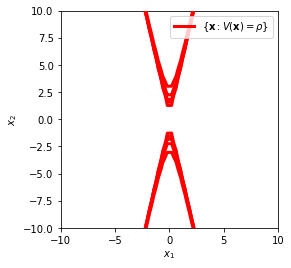

In [161]:
xlim = (-10, 10)

def plot_V(rho):
    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)
    
    # function that evaluates V(x) at a given x
    # (looks bad, but it must accept meshgrids)
    eval_V = lambda x: sum(sum(x[i]*x[j]*Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(S))
    
    # contour plot with only the rho level set
    cs = plt.contour(X1, X2, eval_V([X1, X2]), levels=[rho, 2, 3, 5, 10], colors='r', linewidths=3, zorder=3)
    
    # misc plot settings
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.gca().set_aspect('equal')
    
    # fake plot for legend
    plt.plot(0, 0, color='r', linewidth=3, label=r'$\{ \mathbf{x} : V(\mathbf{x}) = \rho \}$')
    plt.legend()
    
    return cs

f = lambda x: [-x[0] + x[1], 0.1*x[0] - 2*x[1] - x[0]**2 - 0.1*x[0]**3]

v = plot_V(1)
#plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)

In [31]:
#THIS CODE WORKS
from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

def findLambda(x, V, Vdot, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    #V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression()
    
    lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
        
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    prog.AddSosConstraint(lambda_)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
        
    print('Status of first solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(lambda_)


def findV(x, lambda_, f, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    lambda_ = Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-2).ToExpression()
        
    temp, Q = prog.NewSosPolynomial(Variables(x), 2)
    V = temp.ToExpression()
            
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]:0}) == 0)
    
    Vdot = V.Jacobian(x).dot(f)
    
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    
#     prog.AddSosConstraint(np.trace(Q))
    
    A = Q[0, 0]
    B = 2*Q[1, 0]
    C = Q[1, 1]
    
    prog.AddCost(A)
    prog.AddCost(C)
    prog.AddCost(-B)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
        
    k = result.get_solver_details().solution_status
                
    print('Status of second solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(V), result.GetSolution(Q)

def setup_solver():  
    count = 0
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    
    f0 = x[1]
    f1 = (-b/(m*length**2))*x[1] - (grav/length)*(x[0] - (x[0]**3)/6)
    
    f = np.array([f0, f1])
    
    V = x.T@P@x
    
    display(Markdown("$V(x) = " + ToLatex(
    Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
    #Vdot = x.T@P@A@x + x.T@A.T@P@x
    Vdot = V.Jacobian(x).dot(f)
    
    for i in range(2): 
        lambda_ = findLambda(x, V, Vdot, count)
        
        display(Markdown("$\lambda (x) = " + ToLatex(
        Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        V, Q = findV(x, lambda_, f, count)
        
        display(Markdown("$V(x) = " + ToLatex(
        Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        Vdot = V.Jacobian(x).dot(f)
        
        count += 1
    return V, Q
    
    
V, Q = setup_solver()

$V(x) = ( - 0.050968x_{0} x_{1} - 23.285194x_{0}^{2} + 1.186290x_{1}^{2})$

Status of first solver on step 0: 5


AssertionError: 

In [96]:
from pydrake.examples.pendulum import PendulumParams, PendulumPlant


plant = PendulumPlant()
context = plant.CreateDefaultContext()
plant.get_input_port().FixValue(context, [0])
context.SetContinuousState([0, 0])

linearized_plant = Linearize(plant, context)

A = linearized_plant.A()
Q = np.eye(2)
P = RealContinuousLyapunovEquation(A, Q)


p = PendulumParams()

b = p.damping()
m = p.mass()
length = p.length()
g = p.gravity()
grav = p.gravity()

In [99]:
P

array([[2.57851937e+01, 2.54841998e-02],
       [2.54841998e-02, 1.31371050e+00]])

In [100]:
# initialize optimization problem
# initialize optimization problem
prog3 = MathematicalProgram()

# SOS indeterminates
x = prog3.NewIndeterminates(2, 'x')

f0 = x[1]
f1 = (-b/(m*length**2))*x[1] - (grav/length)*(x[0] - (x[0]**3)/6 + (x[0]**5)/120 - (x[0]**7)/5040)
    
f = np.array([f0, f1])

# Lyapunov function
V = x.dot(P).dot(x)
V_dot = 2*x.dot(P).dot(f)

# degree of the polynomial lambda(x)
# no need to change it, but if you really want to,
# keep l_deg even and do not set l_deg greater than 10
l_deg = 2
assert l_deg % 2 == 0

# SOS Lagrange multipliers
l = prog3.NewFreePolynomial(Variables(x), l_deg).ToExpression()

# level set as optimization variable
rho = prog3.NewContinuousVariables(1, 'rho')[0]

# write here the SOS condition described in the "Not quite there yet..." section above
prog3.AddSosConstraint(x.dot(x)*(V - rho) - l*V_dot)

# insert here the objective function (maximize rho)
prog3.AddLinearCost(-rho)


# solve SOS program
result = Solve(prog3)

# get maximum rho
assert result.is_success(), str(result.get_solver_details().solution_status)
rho_method_3 = result.GetSolution(rho)
print(result.GetSolution(l))


# print maximum rho
print(f'Method 3 verified rho = {rho_method_3}.')

(7.7145366481577877 + 4.309693108347967e-17 * x(0) - 4.7275115492219172e-17 * x(1) - 6.5773710708934292 * (x(0) * x(1)) - 0.13018825820217347 * pow(x(0), 2))
Method 3 verified rho = 6.234526607414852.
